# Optimizing AI Trading Algorithms - Course Project


In this project you will practice optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate the concepts covered in the course, such as data preprocessing and cleaning, hyperparameter tuning, detecting and addressing over-/under-fitting, model evaluation, and feature selection techniques. While you will use real-world data in this project, the goal is not necessarily to build a "winning" trading _strategy_. The goal of this course has been to equip you with the tools, techniques, concepts and insights you need to evaluate, optimize and monitor *your own* trading strategies.


## The Scenario

You are an analyst at a boutique investment firm tasked with coming up with a novel idea for investing in specific sectors of the industry. You've heard that the Utilities, Consumer Staples and Healthcare sectors are relatively resilient to economic shocks and recessions, and that stock market investors tend to flock to these sectors in times of uncertainty. You decide to take the [SPDR Healthcase Sector ETF (NYSEARCA: XLV)](https://www.sectorspdrs.com/mainfund/XLV) and try to model its returns' dynamics using a machine learning AI strategy. Your novel idea is to get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) as a proxy for uncertainty in the market. You also decide to take a look at [Google Trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the search term "recession" in the United States, in order to try and see if there is any meaningful relationship between the general public's level of concern about a recession happening and the price movements of the Health Care Select Sector SPDR Fund.


You decide to train a binary **classification** model that merely attempts to predict the **direction** of XLV's 5-day price movements. In other words, you want to see if on any given day, with the above data in hand, you could reliably predict whether the price of XLV will increase or decrease over the next 5 trading days.

Run the cell below to `import` all the Python packages and modules you will be using throughout the project.

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 55.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.2 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 21.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-py3-none-any.whl size=138891 sha256=807f6a2916b56d4ac37e542f96e6e

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  DEPRECATION: ta is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for ta ... done

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

RANDOM_SEED = 42

## 1. Data Acquisition, Exploration, Cleaning and Preprocessing


In this section, you will download and inspect:

- daily data for the SPDR Healthcase Sector ETF (NYSEARCA: XLV)
- daily data for the volatility index (INDEXCBOE: VIX)
- monthly data from Google Trends for the search interest in the term "recession" in the United States

The goal is to make sure the data is clean, meaningful, and usable for selecting and engineering features.


### 1.1. Price and Volume Data for "XLV"


We have downloded daily data from **January 1st, 2004** to **March 31st, 2024** for the ticker **XLV** using the `yfinance` library and stored it in a CSV file named `xlv_data.csv`. Load this data into a Pandas DataFrame named `xlv_data`, making sure to set the index column to the first column of the CSV file (`Date`) and set `parse_dates=True`.


In [4]:
xlv_data = pd.read_csv("xlv_data.csv")

Use the `info()` and `describe()` methods to get an overview of how many rows of data there are in `xlv_data`, what columns are present and what their data types are, and what some basic statistics (mean, std, quartiles, min/max values) of the columns look like.


In [5]:
xlv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5094 non-null   object 
 1   Open       5094 non-null   float64
 2   High       5094 non-null   float64
 3   Low        5094 non-null   float64
 4   Close      5094 non-null   float64
 5   Adj Close  5094 non-null   float64
 6   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 278.7+ KB


In [6]:
xlv_data.describe()

Open         High          Low        Close    Adj Close  \
count  5094.000000  5094.000000  5094.000000  5094.000000  5094.000000   
mean     65.342311    65.730397    64.924197    65.349097    58.242299   
std      36.695351    36.915853    36.477869    36.712468    37.932219   
min      22.010000    22.290001    21.629999    21.879999    16.812475   
25%      31.990000    32.132501    31.812500    31.990000    24.508568   
50%      57.100000    57.400000    56.680000    57.010000    48.387001   
75%      90.657503    91.077497    89.927500    90.557499    82.941315   
max     147.919998   148.270004   147.679993   147.860001   147.729996   

             Volume  
count  5.094000e+03  
mean   7.228951e+06  
std    5.445803e+06  
min    5.870000e+04  
25%    3.790550e+06  
50%    6.582850e+06  
75%    9.559550e+06  
max    6.647020e+07

How many `NaN` rows are there in `xlv_data`?


In [7]:
answer = xlv_data.isnull().sum()
answer

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Take a look at the final five rows of `xlv_data`.


In [8]:
xlv_data.tail()

Date        Open        High         Low       Close   Adj Close  \
5089  2024-03-22  145.850006  146.220001  145.259995  145.440002  145.440002   
5090  2024-03-25  145.710007  145.860001  145.009995  145.240005  145.240005   
5091  2024-03-26  145.529999  145.940002  145.139999  145.770004  145.770004   
5092  2024-03-27  147.009995  147.710007  146.619995  147.710007  147.710007   
5093  2024-03-28  147.919998  148.229996  147.679993  147.729996  147.729996   

       Volume  
5089  5537200  
5090  5253000  
5091  6942400  
5092  8797400  
5093  8090200

Raw OHLC data is not suitable for training models. The absolute price level of a security is boundless in theory and not particularly menaningful. In the next section, you are going to engineer useful features from all of these columns. For now, as a visual sanity check, plot `Adj Close` as a line plot.


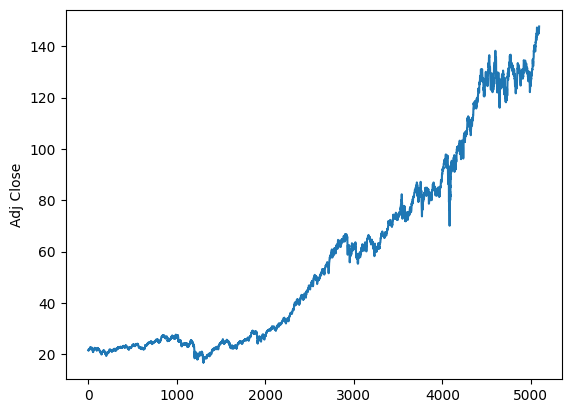

In [9]:
sns.lineplot(xlv_data["Adj Close"]);

**Bonus**: The cell below plots the combined candlestick + volume chart for the last 15 months of data using Plotly.


In [10]:
xlv_data.Date = pd.to_datetime(xlv_data.Date)
xlv_data.set_index("Date", inplace=True)

In [11]:
data_since_2023 = xlv_data["2023-01-01 00:00:00":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

### 1.2. Data for The Volatility Index `VIX`


As before, we have downloaded daily data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) over the same time period using `yfinance` and provided it to you in a CSV file named `vix_data.csv`. Load the data into a variable named `vix_data`. Make sure to set the index and parse the dates correctly.


In [12]:
vix_data = pd.read_csv("vix_data.csv")

In [13]:
vix_data.Date = pd.to_datetime(vix_data.Date)
vix_data.set_index("Date", inplace=True)

Plot a line chart of the `Adj Close` value of the VIX using your method of choice (e.g. `plotly` or `matplotlib`).


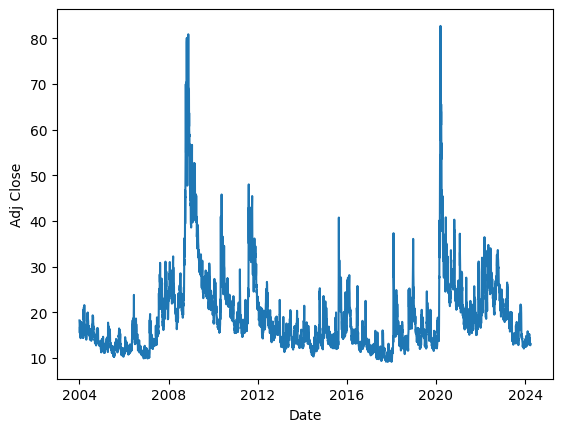

In [14]:
sns.lineplot(vix_data["Adj Close"]);

### 1.3. Google Trends Data


The **monthly** evolution of search interest in the term "recession" in the U.S. over the period of interest (Jan. 2003 - Mar. 2024) from the Google Trends website has been provided to you as a CSV file. We will load this data using Pandas into a DataFrame named `google_trends_data`, set the index column of the DataFrame to the "`Month`" column from the CSV and have Pandas try and parse these dates automatically.

> Note: The "Month" column in the CSV is in "YYYY-MM" format.


In [15]:
google_trends_data = pd.read_csv("GoogleTrendsData.csv")

In [16]:
google_trends_data.head()

Month  recession_search_trend
0  2004-01                       4
1  2004-02                       4
2  2004-03                       5
3  2004-04                       6
4  2004-05                       4

In [17]:
google_trends_data.set_index("Month", inplace=True)

As noted above, the CSV lists **monthly** search trends data and the `Month` column is in YYYY-MM format. How has Pandas interpreted and parsed these into specific dates? Take a look at `google_trends_data`'s index.


In [18]:
google_trends_data.index

Index(['2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06',
       '2004-07', '2004-08', '2004-09', '2004-10',
       ...
       '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11',
       '2023-12', '2024-01', '2024-02', '2024-03'],
      dtype='object', name='Month', length=243)

In [19]:
google_trends_data.index = pd.to_datetime(google_trends_data.index)

We would have liked to assign the data points to the last day of the respective months, as this data would have been available at the _end_ of each period. Shift the index column of `google_trends_data` to do this.

> Hint: You can use `pd.offsets.MonthEnd()` from Pandas.


In [20]:
google_trends_data.index = google_trends_data.index + pd.offsets.MonthEnd()

Run the cell below to visualize this data as a line plot.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


In [21]:
google_trends_data.head()

recession_search_trend
Month                             
2004-01-31                       4
2004-02-29                       4
2004-03-31                       5
2004-04-30                       6
2004-05-31                       4

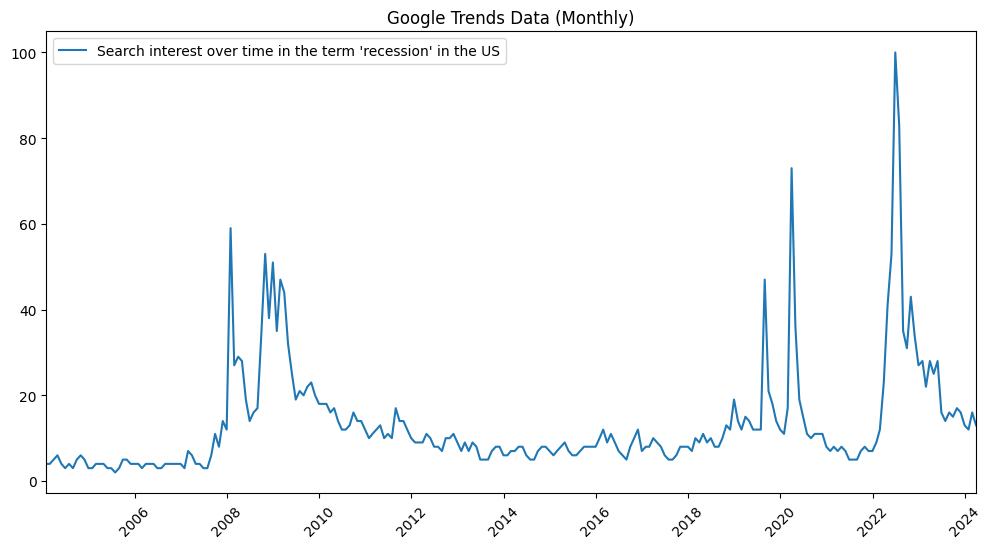

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends_data)
date_fmt = mdates.DateFormatter("%Y-%m")
plt.xlim(google_trends_data.index[0], google_trends_data.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.show()

But not every month-end is a trading day. Also, what value should the model train on for all the days in between month-ends? Below, we have provided you with code to convert the monthly data to daily and interpolate the end-of-month values to get all the in-between values. You will be using this new `google_trends_daily` data going forward.


In [23]:
google_trends_daily = google_trends_data.resample('D').asfreq().interpolate(method='linear')

In [24]:
google_trends_daily.head()

recession_search_trend
Month                             
2004-01-31                     4.0
2004-02-01                     4.0
2004-02-02                     4.0
2004-02-03                     4.0
2004-02-04                     4.0

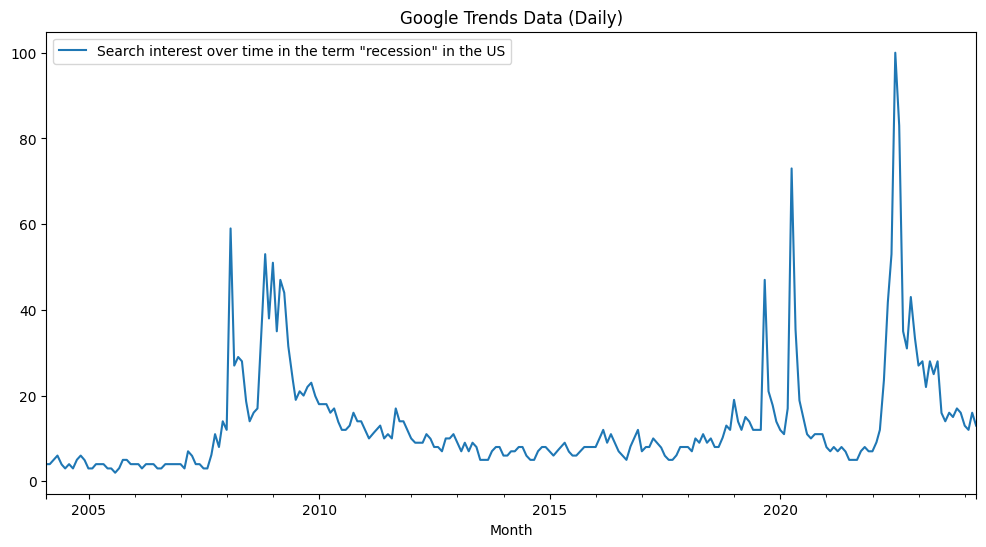

In [25]:
# # The shape of the chart should not have changed
google_trends_daily.plot.line(title="Google Trends Data (Daily)", figsize=(12, 6)).legend(
     labels=['Search interest over time in the term "recession" in the US']);

## 2. Feature Engineering and Analysis


In this section, you will create a new DataFrame called `data` which will house all of the features as well as the prediction target. Then you will analyze the features and look for potentially problematic features.

Start by running the cell below to create `data` as an empty DataFrame with just an index that matches `XLV`'s.


In [26]:
data = pd.DataFrame(index=xlv_data.index)

### 2.1. Feature Engineering


#### 2.1.1. Month and Weekday


Add the `month` and `weekday` columns to `data` as categorical features (integer labels) from its index.


In [27]:
data['month'] = data.index.month
data['weekday'] = data.index.weekday

You do not want to train a model using these columns as they are, because the numbers themselves and the inherent "order" of months and weekdays do not really have any significance, but the model may interpret them as meaningful. You could either (a) use one-hot encoding to turn each category to a separate binary feature, or (b) treat them as cyclical features. The choice is somewhat arbitrary and depends on how important a "feature" you believe the cyclicality to be.

Below, you will:

- Treat `month` as a cyclical feature, creating two features (`month_sin` and `month_cos`). (👉 See: [Trigonometric features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#trigonometric-features))
- One-hot-encode `weekday` and create five additional features of type `int32` (one for each business day) with the `weekday` prefix. (👉 See: [`pandas.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html))
- Make sure the original `month` and `weekday` columns are no longer present in `data`. (`drop()` them if necessary.)


In [28]:
data.head()

month  weekday
Date                      
2004-01-02      1        4
2004-01-05      1        0
2004-01-06      1        1
2004-01-07      1        2
2004-01-08      1        3

In [29]:
# Treat `month` as a "cyclical" feature with a period of 12 months.
data["month_sin"] = np.sin(2 * np.pi * data['month'] / 12)
data["month_cos"] = np.cos(2 * np.pi * data['month'] / 12)

# Treat `weekday` as a "categorical" feature and one-hot-encode it.
data = pd.get_dummies(data, columns=['weekday'], dtype=int)

# Drop the original 'month' column
data.drop(['month'], axis=1, inplace=True)

In [30]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  
Date                   
2004-01-02          1  
2004-01-05          0  
2004-01-06          0  
2004-01-07          0  
2004-01-08          0

#### 2.1.2. Historical Returns


Next, add features for historical returns of the XLV ETF from its `Adj Close` column. For each date, calculate rolling **simple** returns over the past 1, 5, 10 and 20 days. Create 4 columns in `data` named `ret_#d_hist` where `#` is the lookback period. The list `hist_ret_lookbacks` is provided if you wish to use it.


In [31]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_lookbacks = [1, 5, 10, 20]
for lookback in hist_ret_lookbacks:
    data[f'ret_{lookback}d_hist'] = xlv_data['Adj Close'].shift(lookback)

In [32]:
xlv_data['Adj Close'].head(10)

Date
2004-01-02    21.567184
2004-01-05    21.667091
2004-01-06    21.731337
2004-01-07    21.866926
2004-01-08    21.774158
2004-01-09    21.638557
2004-01-12    21.602869
2004-01-13    21.510088
2004-01-14    21.631409
2004-01-15    21.688509
Name: Adj Close, dtype: float64

In [33]:
data.head(10)

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   
2004-01-09        0.5   0.866025          0          0          0          0   
2004-01-12        0.5   0.866025          1          0          0          0   
2004-01-13        0.5   0.866025          0          1          0          0   
2004-01-14        0.5   0.866025          0          0          1          0   
2004-01-15        0.5   0.866025          0          0          0          1   

            weekday_4  ret_1d_hist  ret_5d_hist  ret_10d_hist  ret_20d_hist  
Date                                                                         
2004-01-02          1          NaN          NaN           NaN           NaN  
2004-01-05          0    21.567184          NaN           NaN           NaN  
2004-01-06          0    21.667091          NaN           NaN           NaN  
2004-01-07          0    21.731337          NaN           NaN           NaN  
2004-01-08          0    21.866926          NaN           NaN           NaN  
2004-01-09          1    21.774158    21.567184           NaN           NaN  
2004-01-12          0    21.638557    21.667091           NaN           NaN  
2004-01-13          0    21.602869    21.731337           NaN           NaN  
2004-01-14          0    21.510088    21.866926           NaN           NaN  
2004-01-15          0    21.631409    21.774158           NaN           NaN

The cell below plots the histograms of the returns you just calculated. They should look normally distributed around zero.


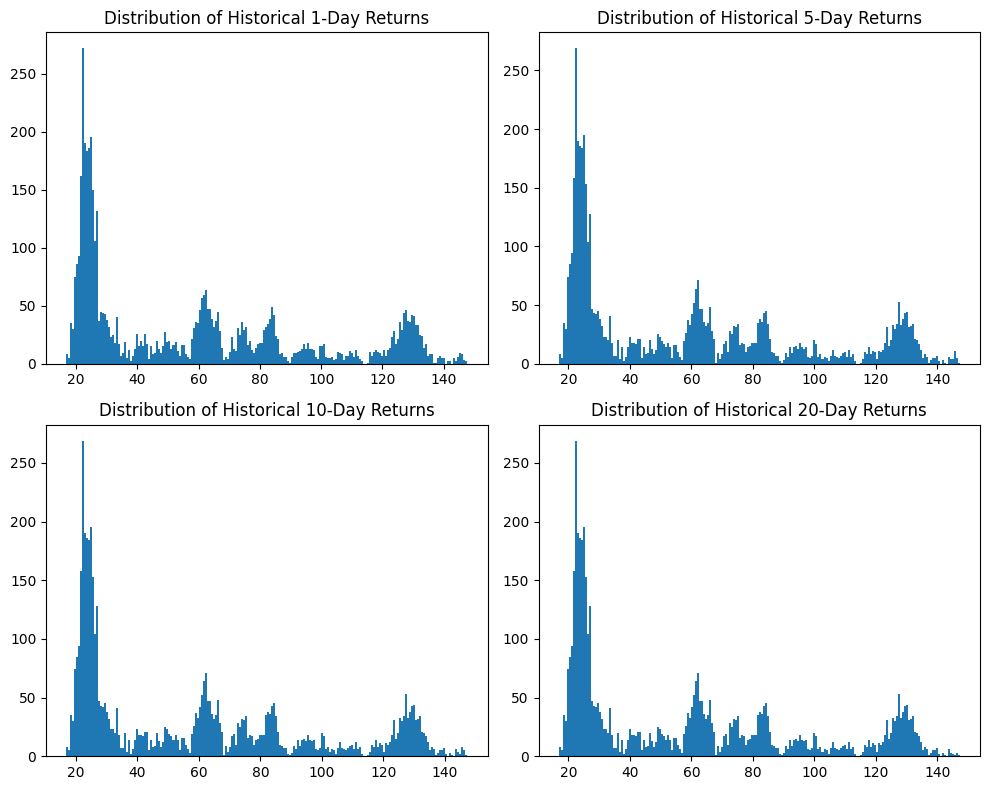

In [34]:
hist_ret_lookbacks = [1, 5, 10, 20] # In case it was deleted from the previous cell

fig, axs = plt.subplots(2, 2, figsize=(10, 8))


def plot_hist_returns(ax, data, col, title):
    ax.hist(data[col], bins=200)
    ax.set_title(title)


for i, n_days in enumerate(hist_ret_lookbacks):
    plot_hist_returns(
        axs[i // 2, i % 2], data, f"ret_{n_days}d_hist", f"Distribution of Historical {n_days}-Day Returns"
    )

plt.tight_layout()
plt.show()

#### 2.1.3. Trade Volumes

As trading volumes span several orders of magnitude, take the natural logarithm of `Volume` and use it as a feature instead. This helps emphasize variations in its lower range. Use `np.log()` and call this new feature `log_volume`.

**Note:** For tree-based models such as Decision Trees and Random Forests, scaling is not necessary. But feature scaling becomes critically important if you use other model types (e.g. distance-based models).


In [35]:
data["log_volume"] = np.log(xlv_data["Volume"])

#### 2.1.4. Technical Indicators

Add a feature named `ibs` which is calculated as (Close - Low) / (High - Low). This measure, a number between zero and one and sometimes referred to as the "Internal Bar Strength", denotes how "strong" the closing price is relative to the high and low prices within the same period.
> **Note:** Make sure to use `Close` (not `Adj Close`).

In [36]:
# Engineer the technical indicator "Internal Bar Strength" (IBS) from XLV's price data
data["ibs"] = (xlv_data["Close"] - xlv_data["Low"]) / (xlv_data["High"] - xlv_data["Low"])

Run the cell below to add a few more technical indicators, including Bollinger Band features and indicators, as well as the Relative Strength Index (RSI).

In [37]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=xlv_data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=xlv_data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high and low indicators
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size and Percentage Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

In [38]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  ret_1d_hist  ret_5d_hist  ret_10d_hist  ret_20d_hist  \
Date                                                                          
2004-01-02          1          NaN          NaN           NaN           NaN   
2004-01-05          0    21.567184          NaN           NaN           NaN   
2004-01-06          0    21.667091          NaN           NaN           NaN   
2004-01-07          0    21.731337          NaN           NaN           NaN   
2004-01-08          0    21.866926          NaN           NaN           NaN   

            log_volume       ibs  bb_bbm  bb_bbh  bb_bbl  bb_bbhi  bb_bbli  \
Date                                                                         
2004-01-02   13.351409  0.312496     NaN     NaN     NaN      0.0      0.0   
2004-01-05   12.162643  0.611113     NaN     NaN     NaN      0.0      0.0   
2004-01-06   12.575219  0.823537     NaN     NaN     NaN      0.0      0.0   
2004-01-07   12.477244  1.000000     NaN     NaN     NaN      0.0      0.0   
2004-01-08   12.275132  0.500000     NaN     NaN     NaN      0.0      0.0   

            bb_bbw  bb_bbp  rsi  
Date                             
2004-01-02     NaN     NaN  NaN  
2004-01-05     NaN     NaN  NaN  
2004-01-06     NaN     NaN  NaN  
2004-01-07     NaN     NaN  NaN  
2004-01-08     NaN     NaN  NaN

In [39]:
data.isnull().sum()

month_sin        0
month_cos        0
weekday_0        0
weekday_1        0
weekday_2        0
weekday_3        0
weekday_4        0
ret_1d_hist      1
ret_5d_hist      5
ret_10d_hist    10
ret_20d_hist    20
log_volume       0
ibs              0
bb_bbm          19
bb_bbh          19
bb_bbl          19
bb_bbhi          0
bb_bbli          0
bb_bbw          19
bb_bbp          19
rsi             13
dtype: int64

#### 2.1.5. The Target of Prediction

Add the column `tgt_is_pos_ret_5d_fut` as type `int` to `data`, denoting whether forward-looking 5-day returns on each day are positive (a value of `1`) or negative (a value of `0`).
> **Note:** Again, as before, calculte **simple** returns from the `Adj Close` column of `xlv_data`.

In [40]:
# Create the prediction target: an integer indicating whether future 5-day returns are positive (1) or negative (0)
data['tgt_is_pos_ret_5d_fut'] = (xlv_data['Adj Close'].pct_change(5).shift(-5) > 0).astype(int)

Run the cells below to get an idea of how balanced the distribution of the target variable is throughout the data.

In [41]:
target_col_name = "tgt_is_pos_ret_5d_fut"
# Inspect the distribution of the target variable
target_value_counts = data[target_col_name].value_counts()
target_value_counts / len(data)


tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

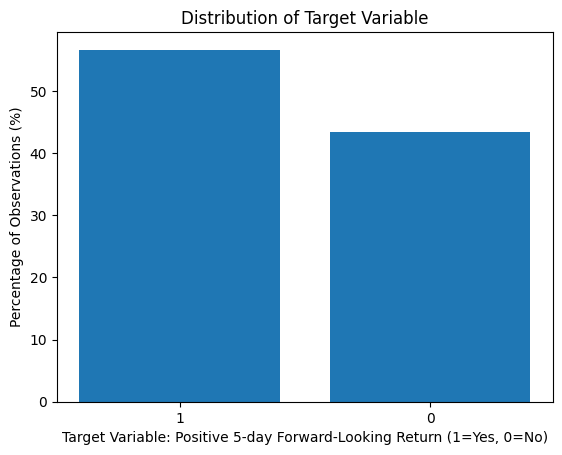

In [42]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Forward-Looking Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

Does the data look relatively balanced or grossly unbalanced in the distribution of the target variable? Why is this important?


Answer = The data appears to be relatively balanced in terms of the distribution of the target variable. A balanced dataset is generally desirable for machine learning models, especially classification models to avoid bias, improve accuracy and to bring fairness.

#### 2.1.6. Stitching Everything Together

You will now add the `vix_data` and `google_trends_daily` as features to `data`. You will also rename the column corresponding to the VIX feature. Run the cell below to do so.

In [43]:
# Join with the Google Trends data and VIX data
data = data.join(google_trends_daily, how="left")
data = data.join(vix_data["Adj Close"], how="left")
data.rename(columns={"Adj Close": "vix"}, inplace=True)

In [44]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  ret_1d_hist  ret_5d_hist  ret_10d_hist  ret_20d_hist  \
Date                                                                          
2004-01-02          1          NaN          NaN           NaN           NaN   
2004-01-05          0    21.567184          NaN           NaN           NaN   
2004-01-06          0    21.667091          NaN           NaN           NaN   
2004-01-07          0    21.731337          NaN           NaN           NaN   
2004-01-08          0    21.866926          NaN           NaN           NaN   

            log_volume       ibs  bb_bbm  bb_bbh  bb_bbl  bb_bbhi  bb_bbli  \
Date                                                                         
2004-01-02   13.351409  0.312496     NaN     NaN     NaN      0.0      0.0   
2004-01-05   12.162643  0.611113     NaN     NaN     NaN      0.0      0.0   
2004-01-06   12.575219  0.823537     NaN     NaN     NaN      0.0      0.0   
2004-01-07   12.477244  1.000000     NaN     NaN     NaN      0.0      0.0   
2004-01-08   12.275132  0.500000     NaN     NaN     NaN      0.0      0.0   

            bb_bbw  bb_bbp  rsi  tgt_is_pos_ret_5d_fut  \
Date                                                     
2004-01-02     NaN     NaN  NaN                      1   
2004-01-05     NaN     NaN  NaN                      0   
2004-01-06     NaN     NaN  NaN                      0   
2004-01-07     NaN     NaN  NaN                      0   
2004-01-08     NaN     NaN  NaN                      0   

            recession_search_trend        vix  
Date                                           
2004-01-02                     NaN  18.219999  
2004-01-05                     NaN  17.490000  
2004-01-06                     NaN  16.730000  
2004-01-07                     NaN  15.500000  
2004-01-08                     NaN  15.610000

### 2.2. Further Data Preprocessing and Cleaning


While engineering new features, some `NaN` values were created. You now need to clean the combined DataFrame. Inspect `data` to see how many `NaN` values there are per column.

In [45]:
data.isnull().sum()

month_sin                  0
month_cos                  0
weekday_0                  0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
ret_1d_hist                1
ret_5d_hist                5
ret_10d_hist              10
ret_20d_hist              20
log_volume                 0
ibs                        0
bb_bbm                    19
bb_bbh                    19
bb_bbl                    19
bb_bbhi                    0
bb_bbli                    0
bb_bbw                    19
bb_bbp                    19
rsi                       13
tgt_is_pos_ret_5d_fut      0
recession_search_trend    20
vix                        0
dtype: int64

Some features, such as historical returns, RSI, Bollinger Bands and BB indicators cannot be calculated for the first `n` days due to their "rolling" nature. In general, missing values can sometimes be imputed with reasonable estimates. But here you will simply drop the rows containing them. The largest `n` is `20`, corresponding to the calculation of 20-day historical returns. Drop the first 20 rows of `data`.


In [46]:
data = data.iloc[20:]

Are there any more missing values?

In [47]:
data.isnull().sum()

month_sin                 0
month_cos                 0
weekday_0                 0
weekday_1                 0
weekday_2                 0
weekday_3                 0
weekday_4                 0
ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
log_volume                0
ibs                       0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
bb_bbp                    0
rsi                       0
tgt_is_pos_ret_5d_fut     0
recession_search_trend    0
vix                       0
dtype: int64

Even if there aren't, you remember that when you calculated the target variable (`tgt_is_pos_ret_5d_fut`) based on forward-looking 5-day rolling returns, you could not have known future returns for the last five days of `data`! Therefore the last 5 rows of data should be dropped.


In [48]:
## YOUR CODE HERE ##

Let us take a final look at the types and statistical characteristics of the set of features and targets.


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5074 entries, 2004-02-02 to 2024-03-28
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month_sin               5074 non-null   float64
 1   month_cos               5074 non-null   float64
 2   weekday_0               5074 non-null   int64  
 3   weekday_1               5074 non-null   int64  
 4   weekday_2               5074 non-null   int64  
 5   weekday_3               5074 non-null   int64  
 6   weekday_4               5074 non-null   int64  
 7   ret_1d_hist             5074 non-null   float64
 8   ret_5d_hist             5074 non-null   float64
 9   ret_10d_hist            5074 non-null   float64
 10  ret_20d_hist            5074 non-null   float64
 11  log_volume              5074 non-null   float64
 12  ibs                     5074 non-null   float64
 13  bb_bbm                  5074 non-null   float64
 14  bb_bbh                

In [50]:
data.describe()

month_sin     month_cos    weekday_0    weekday_1    weekday_2  \
count  5.074000e+03  5.074000e+03  5074.000000  5074.000000  5074.000000   
mean  -1.850557e-03 -7.564581e-03     0.186638     0.205164     0.205755   
std    7.100602e-01  7.042379e-01     0.389659     0.403861     0.404292   
min   -1.000000e+00 -1.000000e+00     0.000000     0.000000     0.000000   
25%   -8.660254e-01 -8.660254e-01     0.000000     0.000000     0.000000   
50%   -2.449294e-16  6.123234e-17     0.000000     0.000000     0.000000   
75%    8.660254e-01  5.000000e-01     0.000000     0.000000     0.000000   
max    1.000000e+00  1.000000e+00     1.000000     1.000000     1.000000   

         weekday_3    weekday_4  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
count  5074.000000  5074.000000  5074.000000  5074.000000   5074.000000   
mean      0.202207     0.200236    58.361036    58.263347     58.141737   
std       0.401686     0.400217    37.920515    37.854050     37.772350   
min       0.000000     0.000000    16.812475    16.812475     16.812475   
25%       0.000000     0.000000    24.546034    24.538646     24.521158   
50%       0.000000     0.000000    48.901531    48.808598     48.387001   
75%       0.000000     0.000000    82.975199    82.941315     82.859783   
max       1.000000     1.000000   147.710007   147.328003    147.328003   

       ret_20d_hist   log_volume          ibs       bb_bbm       bb_bbh  \
count   5074.000000  5074.000000  5074.000000  5074.000000  5074.000000   
mean      57.897260    15.409557     0.534046    65.270078    67.226787   
std       37.605782     1.081480     0.308050    36.560834    37.709216   
min       16.812475    10.980195     0.000000    23.217500    24.569328   
25%       24.479019    15.158747     0.258897    32.043375    32.791758   
50%       47.872692    15.704026     0.546169    57.399250    58.841503   
75%       82.679218    16.074700     0.818179    90.414125    93.279840   
max      147.328003    18.012264     1.000000   146.183501   148.369194   

            bb_bbl      bb_bbhi      bb_bbli       bb_bbw       bb_bbp  \
count  5074.000000  5074.000000  5074.000000  5074.000000  5074.000000   
mean     63.313369     0.061096     0.054001     5.944045     0.567262   
std      35.457282     0.239530     0.226042     3.644928     0.326527   
min      20.419952     0.000000     0.000000     1.165471    -0.452267   
25%      31.153274     0.000000     0.000000     3.789063     0.310016   
50%      54.818195     0.000000     0.000000     5.050339     0.622854   
75%      87.517164     0.000000     0.000000     7.011053     0.832542   
max     144.646172     1.000000     1.000000    32.354816     1.349959   

               rsi  tgt_is_pos_ret_5d_fut  recession_search_trend          vix  
count  5074.000000            5074.000000             5074.000000  5074.000000  
mean     53.685786               0.565432               13.291106    19.093841  
std      11.249638               0.495749               12.472799     8.745523  
min      13.539141               0.000000                2.032258     9.140000  
25%      46.025361               0.000000                6.322581    13.370000  
50%      54.069737               1.000000                9.241667    16.535001  
75%      61.827506               1.000000               14.903226    22.100000  
max      85.413254               1.000000              100.000000    82.690002

### 2.3. Correlation Analysis


Correlation analysis can be a rough and early form of feature importance analysis. Features that are highly correlated (in either direction) with each other but not with the target variable, are a sign of multicollinearity problems, which means they may not contribute much additional information in predicting the target. In fact, depending on the algorithm used, multicollinearity may result in stability and reliability issues. Checking the correlation matrix can be helpful in identifying such features.  

Plot the heatmap of the correlation matrix of features/target and identify a cluster of 3 features that are almost certainly collinear. (Hint: `bb_bbm` is one of them.) You can pass the correlation matrix directly to [Seaborn's `heatmap()` method](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

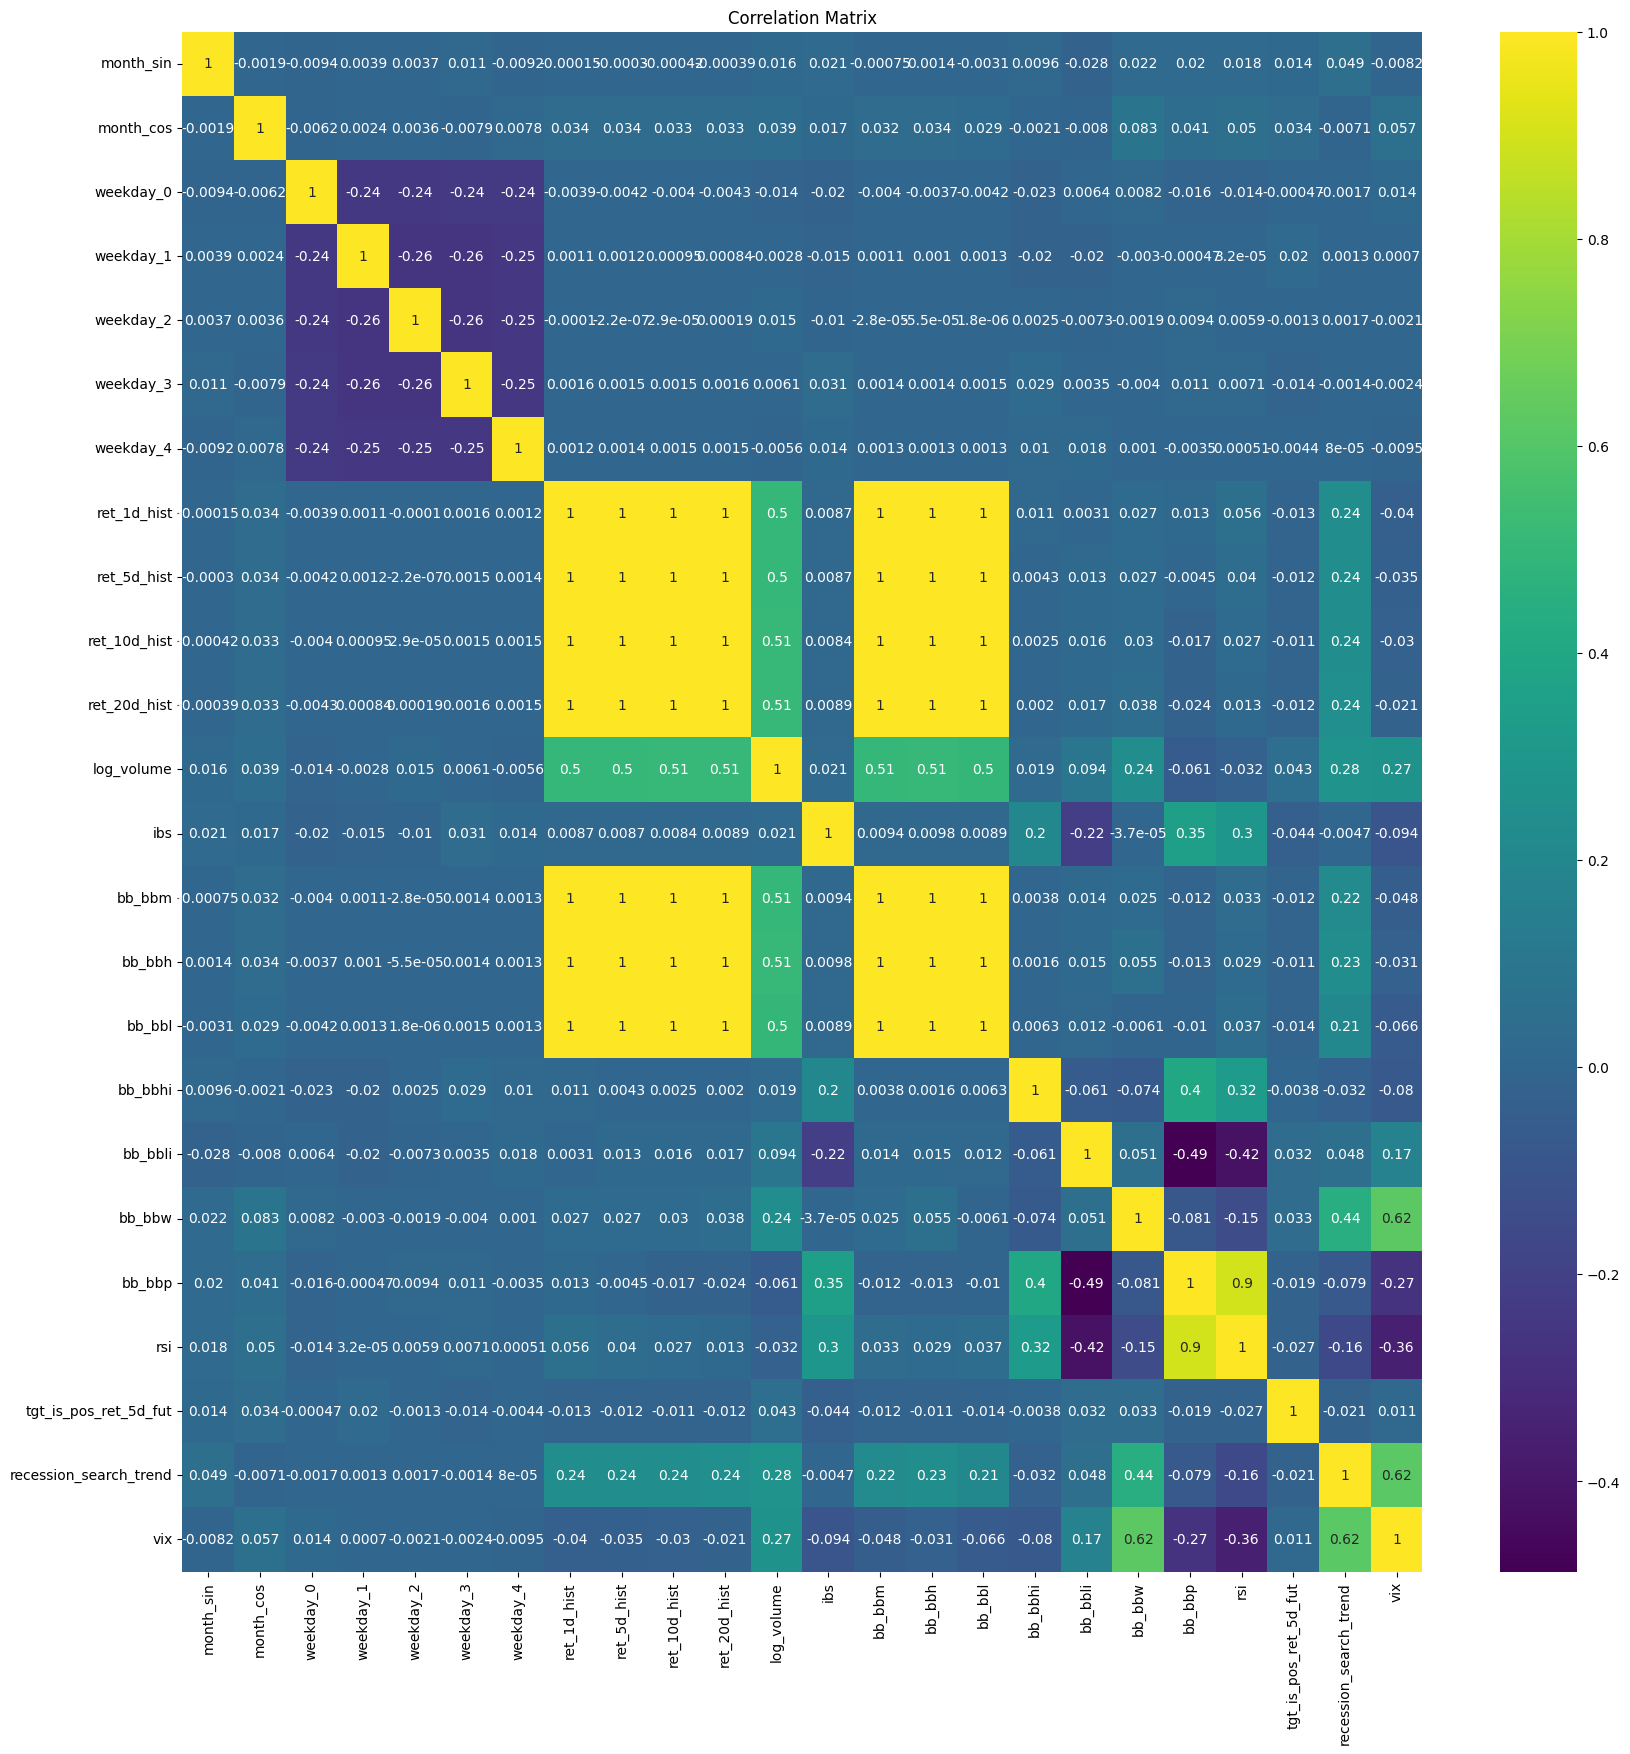

In [52]:
corr_matrix = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

In such scenarios, we usually eliminate all but one of the collinear features. Keep `bb_bbm` and drop the other two features that are highly linearly related to it.

In [56]:
data.drop(['bb_bbh', 'bb_bbl'], axis=1, inplace=True)

In [57]:
data.columns

Index(['month_sin', 'month_cos', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'ret_1d_hist', 'ret_5d_hist', 'ret_10d_hist',
       'ret_20d_hist', 'log_volume', 'ibs', 'bb_bbm', 'bb_bbhi', 'bb_bbli',
       'bb_bbw', 'bb_bbp', 'rsi', 'tgt_is_pos_ret_5d_fut',
       'recession_search_trend', 'vix'],
      dtype='object')

There is also one feature that is very highly correlated with `rsi` (which makes intuitive sense, as it, too, is a measure of relative strength). Find it an eliminate it, leaving `rsi` intact.

In [58]:
data.drop(['bb_bbp'], axis=1, inplace=True)

In [59]:
data.columns

Index(['month_sin', 'month_cos', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'ret_1d_hist', 'ret_5d_hist', 'ret_10d_hist',
       'ret_20d_hist', 'log_volume', 'ibs', 'bb_bbm', 'bb_bbhi', 'bb_bbli',
       'bb_bbw', 'rsi', 'tgt_is_pos_ret_5d_fut', 'recession_search_trend',
       'vix'],
      dtype='object')

Plot the heatmap of the new, reduced correlation matrix.

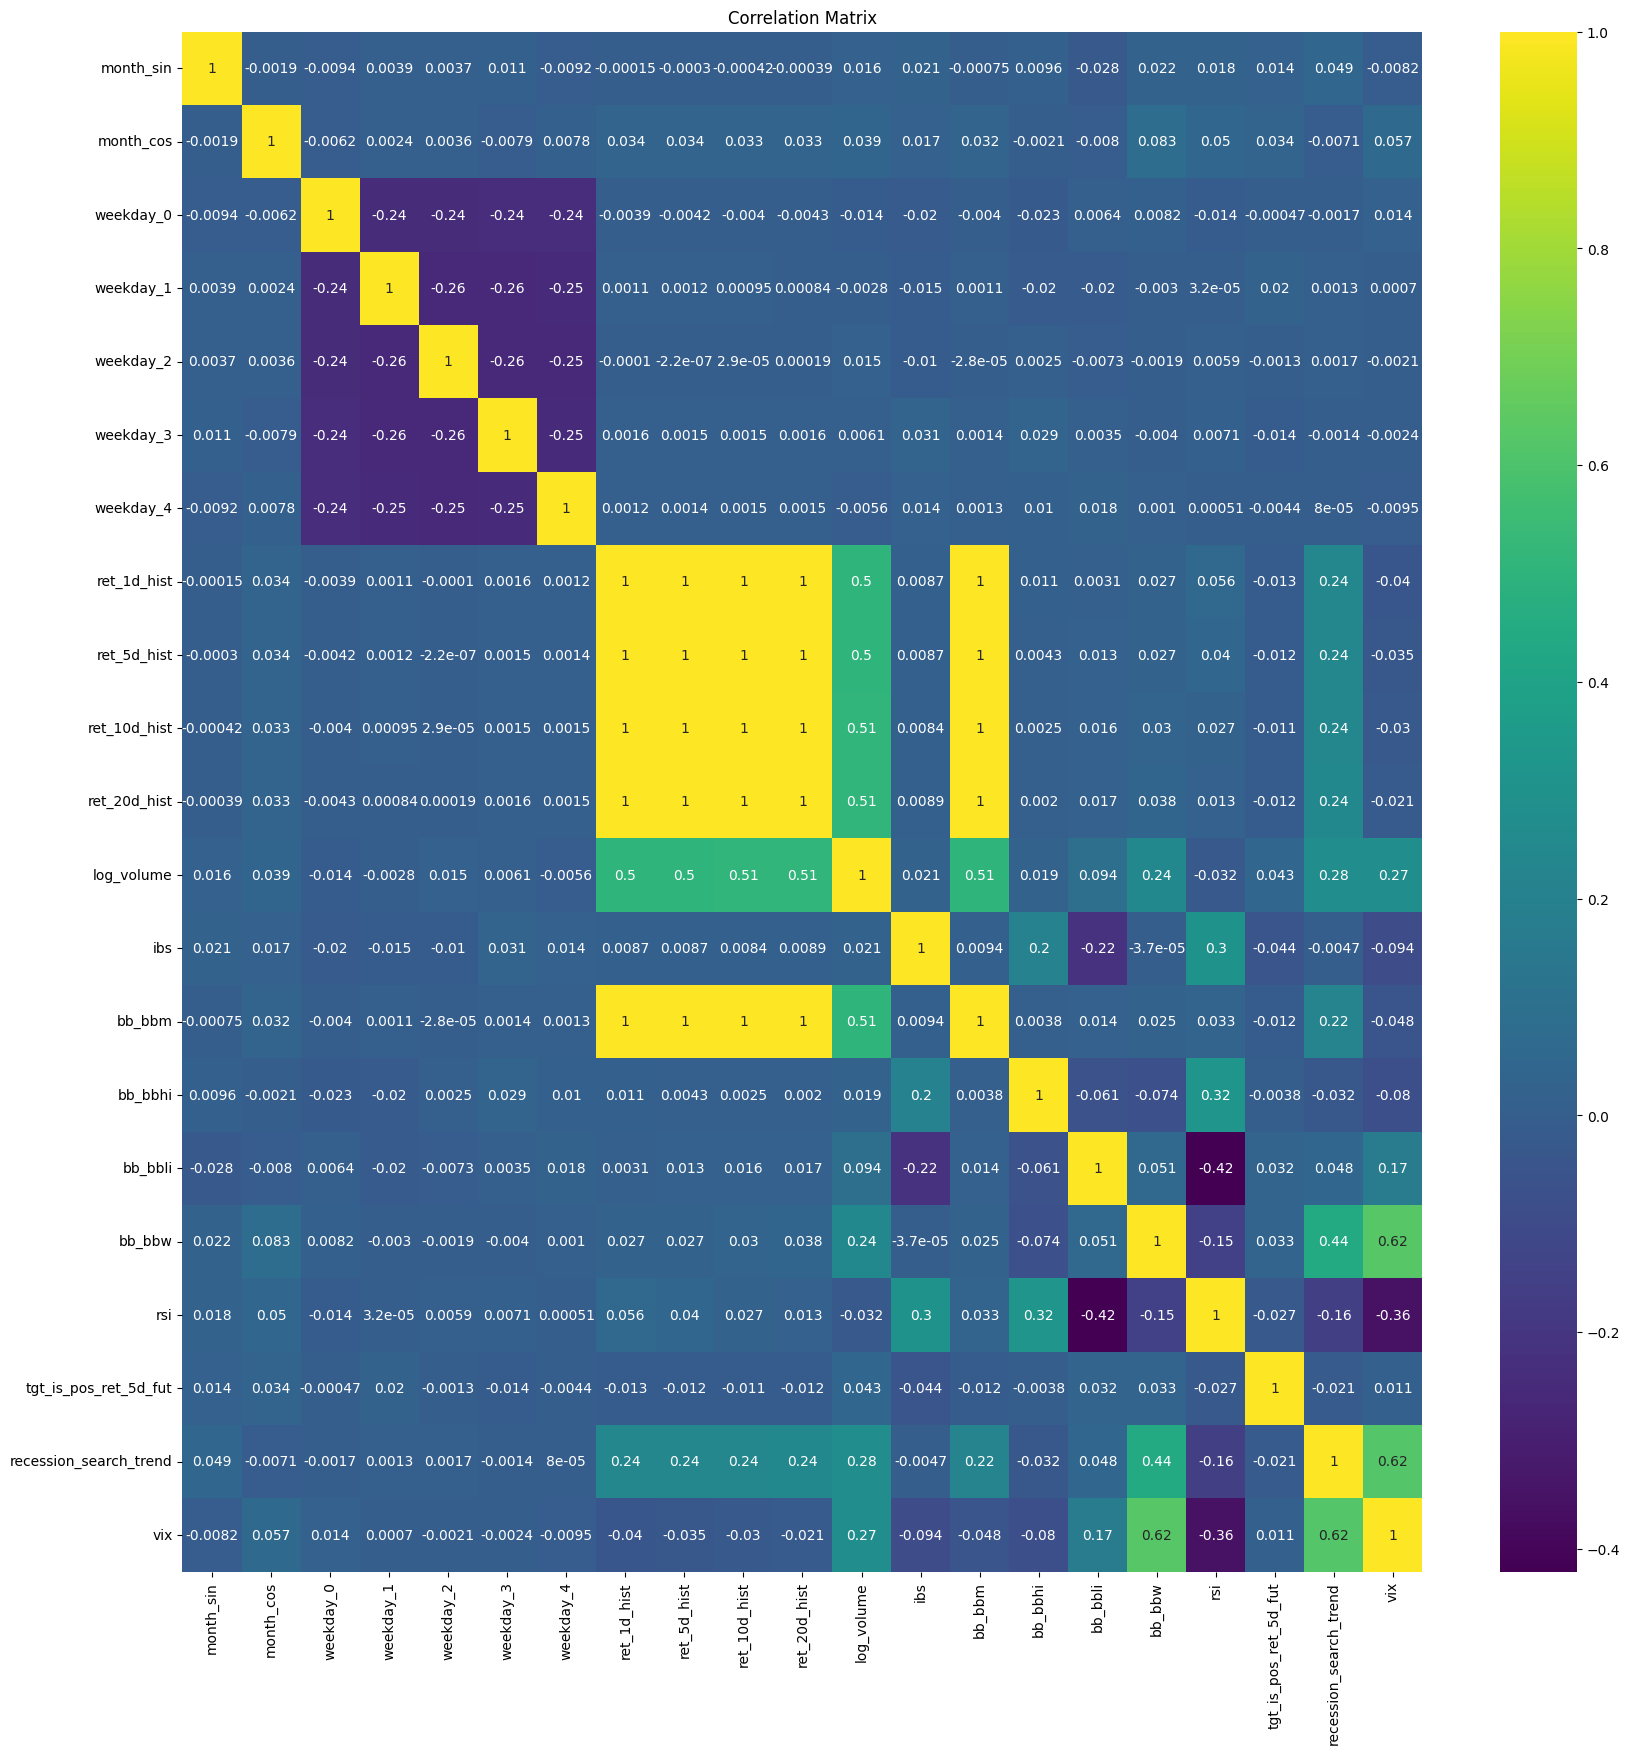

In [60]:
corr_matrix = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

Features that are highly correlated (negatively or positively) **with the target variable** are likely more important. Which two (2) independent variables (features) are correlated more than 4% (**in either direction**) with the boolean target variable denoting whether 5-day future returns are positive?


Answer = log_volume, ibs

## 3. The Training-Validation-Testing Split


In this section, you will split the `data` set into two sets: the training and validation set, and the testing set. You will then come up with a baseline score so that you have a reference point for evaluating your model's performance.

**Note:** Technically, since you are not going to use classical statistics-based time-series prediction methods (such as ARIMA), you can shuffle the data before splitting it. But for ease of interpretability and backtesting, you may as well keep the data in its original order. This is fine as long as the distributions of features and the target variable do not significantly shift over time. - And that is an important assumption related to drift analysis, which was covered in the course, but we will not get to in this project.

### 3.1. The Split


It is time to split the data, temporally, into the training + validation and testing sets. You will train and optimize (i.e. cross-validate) your model on the first 80% of the data, and use the remaining 20% for the test set (i.e. to evaluate the performance of your model). Use the `train_test_split()` method from scikit-learn's `model_selection` module to perform the split.
> **Note:** Please make sure to set `shuffle=False` and `random_state=RANDOM_STATE`.

In [61]:
X = data.drop('tgt_is_pos_ret_5d_fut', axis=1)
y = data['tgt_is_pos_ret_5d_fut']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

### 3.2. Baseline Model and Score


Earlier, you inspected the distribution of the target variable across the entire data set. Run the cell below to analyze at the distribution of the target variable in each split.

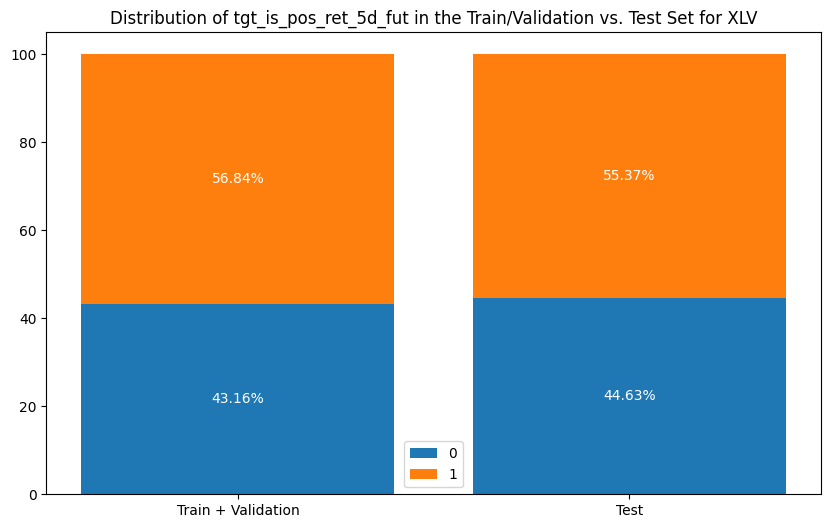

In [62]:
train_val_pct = y_train_val.value_counts(normalize=True) * 100
test_pct = y_test.value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_pct[0], test_pct[0]]
one_counts = [train_val_pct[1], test_pct[1]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )
ax.set_title(f"Distribution of {target_col_name} in the Train/Validation vs. Test Set for XLV")
ax.legend()

plt.show()

If you were to devise a simple model that naively always predicted the majority class, what would the accuracy score of your model be on the training+validation set? How about on the testing set? Consider the latter your baseline score, i.e. a reference score to compare your more sophisticated model's performace to.

baseline_accuracy_test_score = 55.37%

## 4. Model Training and Tuning


In this section, you will train a `RandomForestClassifier`, a robust, versatile ensemble learning method that uses "bagging" (also known as "bootstrap aggregating") to train multiple Decision Trees. The technical details of the model are beyond the scope of this course, but you may read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Run the cell below which defines a function that allows you to plot learning curves annotated with a hyperparameter named `max_depth` which you pass to it.

In [63]:
def plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title(f"Learning Curves (max_depth={max_depth})")
    axs.legend(loc="center left")
    axs.grid(True)

Below is the first iteration of your model. It uses the default values for most of its hyperparameters. We have only specified one hyperparameter, `max_depth=10`.

In [64]:
max_depth = 10
model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)

Use the `learning_curve()` method from scikit-learn's `model_selection` module to cross-validate your model, with `accuracy` as the `scoring` metric. Use 10%, 20%, 30%,... , and 100% of the training+validatin data, with 5-fold cross-validation.

In [68]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
train_sizes, train_scores, test_scores =learning_curve(model, 
                                                       X_train_val, 
                                                       y_train_val, 
                                                       scoring='accuracy', 
                                                       train_sizes=train_sizes,
                                                       cv=5)

Inspect the learning curves.

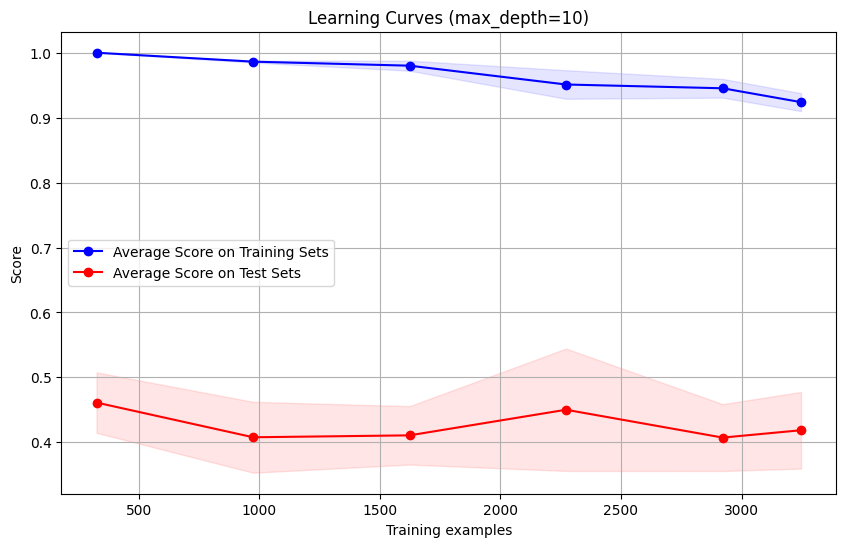

In [69]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs)

plt.show()

Wondering what effect different values of the `max_depth` hyperparameter have, you decide to experiment with lower (`10`) and higher (`20`) values of it to see how the plots change. Run the cell below to help you answer the questions that follow it.


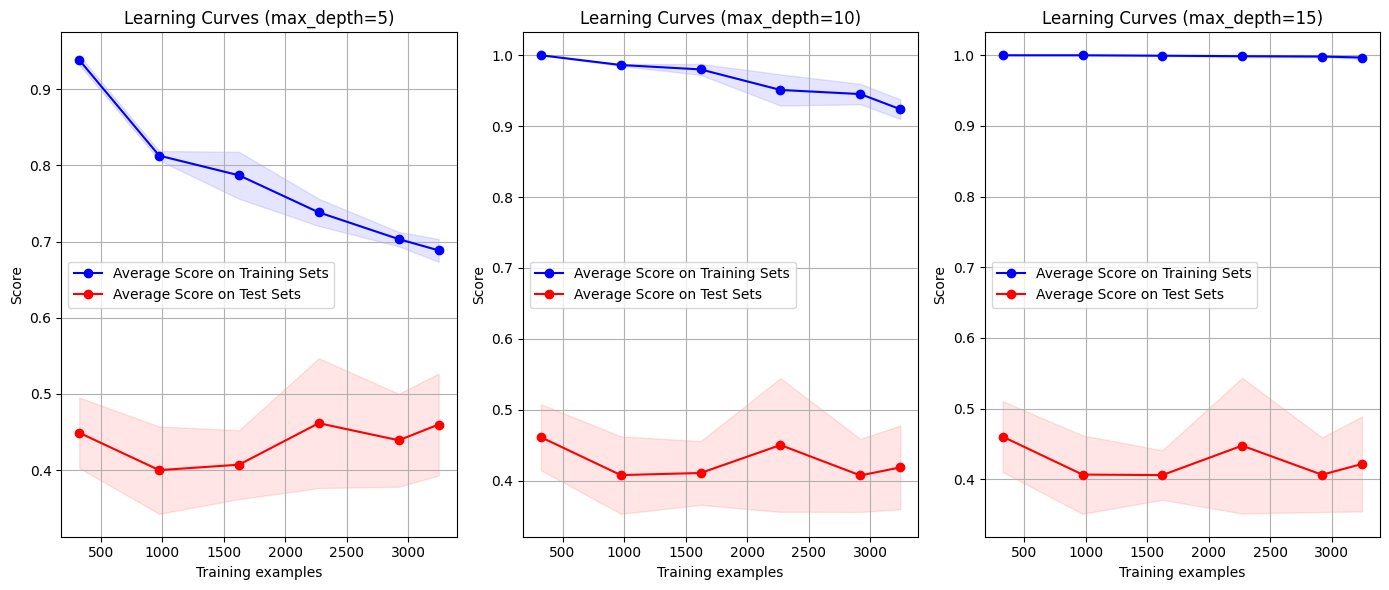

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [5, 10, 15]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs[i])

plt.tight_layout()
plt.show()

With a value of `max_depth=15`, does your model overfit or underfit?


Answer = Overfit. Training accuracy is always 1 and there is a gap between the training score and test score with training score always on the higher side.

With a value of `max_depth=15`, is your performance metric (accuracy score) more likely to improve with more training data or with higher model complexity?

Answer = Increasing the model's complexity, such as by increasing the number of trees in the random forest or using a deeper model, can help the model capture more complex patterns in the data.Adding more training data might help to some extent, but it's unlikely to be as effective as increasing model complexity when dealing with overfitting. More data can help the model generalize better, but it might not be enough to overcome the overfitting

Random Forest Classifiers have several other hyperparameters, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100). So far, you have been tuning your model manually. But with all the possible combinations of hyperparameters, this is not tractable.  

Use grid search cross-validation (the `GridSearchCV` class from scikit-learn's `model_selection` module) to find the optimal combination of hyperparameters from the search space specified below:
- `max_depth` = 2, 3, 4 or 5
- `min_samples_leaf` = 1, 2, 3 or 4
- `n_estimators` = 50, 75, 100, 125, or 150

As before, use 5-fold cross-validation and accuracy as the `scoring` metric. Name your tuning model `search`.

> Note: Setting `n_jobs=-1` will allow Python to take advantage of parallel computing on your computer to speed up the training.

In [72]:
max_depth = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4]
n_estimators = [50, 75, 100, 125, 150]

grid = {'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators}

search = GridSearchCV(model, grid, scoring='accuracy', cv=5)

search.fit(X_train_val, y_train_val)

/opt/venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, n_jobs=-1,
                                              random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='accuracy')

Run the cell below to see the top 5 best performing hyperparameter combinations.

In [73]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2        0.215919      0.003234         0.006548        0.001040   
12       0.230402      0.011678         0.007357        0.000459   
17       0.224046      0.003744         0.006657        0.000846   
7        0.218050      0.003421         0.006157        0.000105   
18       0.285102      0.009215         0.008239        0.001415   

    param_max_depth  param_min_samples_leaf  param_n_estimators  \
2                 2                       1                 100   
12                2                       3                 100   
17                2                       4                 100   
7                 2                       2                 100   
18                2                       4                 125   

                                               params  split0_test_score  \
2   {'max_depth': 2, 'min_samples_leaf': 1, 'n_est...           0.450739   
12  {'max_depth': 2, 'min_samples_leaf': 3, 'n_est...           0.450739   
17  {'max_depth': 2, 'min_samples_leaf': 4, 'n_est...           0.450739   
7   {'max_depth': 2, 'min_samples_leaf': 2, 'n_est...           0.450739   
18  {'max_depth': 2, 'min_samples_leaf': 4, 'n_est...           0.435961   

    split1_test_score  split2_test_score  split3_test_score  \
2            0.346059           0.567734           0.567734   
12           0.346059           0.567734           0.567734   
17           0.346059           0.567734           0.567734   
7            0.346059           0.567734           0.567734   
18           0.347291           0.567734           0.567734   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
2            0.500617         0.486577        0.082945                1  
12           0.500617         0.486577        0.082945                1  
17           0.500617         0.486577        0.082945                1  
7            0.490752         0.484604        0.082705                4  
18           0.495684         0.482881        0.083845                5

Looking at the results of GridSearchCV, which hyperparameters yield the highest mean test score?


In [74]:
best_max_depth = 2
best_min_samples_leaf = 4
best_n_estimators = 100


Looking more closely at the DataFrame of top 5 results, varying which hyperparameter did not seem to have any effect, at least in the top-ranking score?

Answer = min_samples_leaf

## 5. Model Evaluation and Interpretation


In this section, you will evaluate the performance metrics of the best model you found in the previous section and analyze feature importance in relation to model performance.

### 5.1. Evaluation (Performance Metrics)


It is finally time to train your model on the entire training + validation set with the optimal set of hyperparameters you just found, and evaluate its performance on the test set.  

Train (`fit()`) a `RandomForestClassifier` on the training data with the optimal combination of hyperparameters you found in the previous section. Name it 'clf'.

> **Note:** Remember to set `random_state=RANDOM_SEED` for consistency of results, and set `n_jobs=-1` to automatically speed up the run.

In [75]:
clf = RandomForestClassifier(max_depth=best_max_depth, 
                             min_samples_leaf=best_min_samples_leaf,
                             n_estimators=best_n_estimators,
                             random_state=RANDOM_SEED,
                             n_jobs=-1)
clf.fit(X_train_val, y_train_val)

RandomForestClassifier(max_depth=2, min_samples_leaf=4, n_jobs=-1,
                       random_state=42)

Store your trained model's predictions on the **testing** set in a variable named `y_test_pred`.

In [76]:
y_test_pred = clf.predict(X_test)

Complete the Python dictionary in the code cell below to evaluate your model and answer the questions that follow.

In [77]:
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred)
}
display(evaluation)

{'accuracy': 0.47389162561576353,
 'precision': np.float64(0.6666666666666666),
 'recall': np.float64(0.099644128113879),
 'f1': np.float64(0.17337461300309598)}

Explain, in words and citing the actual numbers from the evaluation report above, what the **precision** and **recall** scores mean.

Answer = Our model has a relatively high precision, meaning that when it predicts a positive outcome, it's usually correct. However, it has a very low recall, indicating that it's missing a large number of actual positive cases. This could be due to the model being overly cautious or not sensitive enough to detect the positive cases.

Run the cell below to get a more detailed report.

In [78]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.46      0.94      0.61       453
           1       0.67      0.10      0.17       562

    accuracy                           0.47      1015
   macro avg       0.56      0.52      0.39      1015
weighted avg       0.57      0.47      0.37      1015



How many True Negatives, False Negatives, False Positives and True Positives did the model predict on the test set? Find out using the `confusion_matrix()` method from scikit-learn's `metrics` module. 

In [79]:
confusion_matrix(y_test, y_test_pred)

array([[425,  28],
       [506,  56]])

Answer the question from earlier.
> Note: Feel free to rename the variables. We will not reference them later.

In [80]:
num_TrueNeg = 425
num_FalseNeg = 506
num_FalsePos = 28
num_TruePos = 56

Is the model overfitting or underfitting? Did it manage to capture the variance on the training set but fail to generalize to the testing set? Take a look at the `classification_report()` and `confusion_matrix()` on the **training** data.

In [81]:
y_train_val_pred = clf.predict(X_train_val)
print(classification_report(y_train_val, y_train_val_pred))

              precision    recall  f1-score   support

           0       0.96      0.01      0.03      1752
           1       0.57      1.00      0.73      2307

    accuracy                           0.57      4059
   macro avg       0.77      0.51      0.38      4059
weighted avg       0.74      0.57      0.43      4059



In [82]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[  24, 1728],
       [   1, 2306]])

How does your model's performance compare to the baseline in terms of `accuracy`?


Answer = I can see no improvement in the model's performance when compared to the baseline. The baseline has a avg accuracy of 56% approx and optimized model's accuracy is 47%

How do the `precision` and `recall` of your model compare to those of the baseline model?

Answer = we cannot really answer this since we do not have the actually data about the False postives and False negatives for the baseline assumption.

### 5.2. Revisiting Feature Importance


You decide to see if there are any features that are not contributing significantly to the performance of the model. Use the `feature_importances_` property of your classifier.


In [84]:
importances = search.best_estimator_.feature_importances_

# Calculate the sum of importances
total_importance = sum(importances)

# Calculate the percentage for each feature
feature_percentages = [(importance / total_importance) * 100 for importance in importances]

# Print the feature importances as percentages
for feature, percentage in zip(X.columns, feature_percentages):
    print(f"{feature}: {percentage:.3f}%")

month_sin: 2.249%
month_cos: 4.087%
weekday_0: 0.023%
weekday_1: 0.065%
weekday_2: 0.000%
weekday_3: 0.000%
weekday_4: 0.078%
ret_1d_hist: 13.958%
ret_5d_hist: 7.864%
ret_10d_hist: 7.290%
ret_20d_hist: 15.201%
log_volume: 6.382%
ibs: 9.214%
bb_bbm: 6.900%
bb_bbhi: 0.000%
bb_bbli: 0.129%
bb_bbw: 4.945%
rsi: 3.543%
recession_search_trend: 10.826%
vix: 7.245%


Create a new training set named `X_train_val_reduced` and a new testing set named `X_test_reduced` by eliminating any features from the old train/test sets that had a feature importance of less than `0.5%`.

In [85]:
# Drop features that have an importance of 0.05% or less...
feats_to_drop = ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'bb_bbhi', 'bb_bbli']
X_train_val_reduced = X_train_val.drop(feats_to_drop, axis=1)
X_test_reduced = X_test.drop(feats_to_drop, axis=1)

Re-do your grid search cross-validation with the same grid of hyperparameters as before but with the **reduced** feature set.

In [86]:
max_depth = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4]
n_estimators = [50, 75, 100, 125, 150]

grid = {'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators}

search = GridSearchCV(model, grid, scoring='accuracy', cv=5)

search.fit(X_train_val_reduced, y_train_val)

/opt/venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, n_jobs=-1,
                                              random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='accuracy')

In [87]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
40       0.177261      0.002829         0.004633        0.000191   
46       0.260606      0.002179         0.005488        0.000323   
45       0.174988      0.003449         0.004635        0.000495   
41       0.264296      0.007234         0.005735        0.000442   
50       0.175329      0.001470         0.004528        0.000202   

    param_max_depth  param_min_samples_leaf  param_n_estimators  \
40                4                       1                  50   
46                4                       2                  75   
45                4                       2                  50   
41                4                       1                  75   
50                4                       3                  50   

                                               params  split0_test_score  \
40  {'max_depth': 4, 'min_samples_leaf': 1, 'n_est...           0.453202   
46  {'max_depth': 4, 'min_samples_leaf': 2, 'n_est...           0.444581   
45  {'max_depth': 4, 'min_samples_leaf': 2, 'n_est...           0.454433   
41  {'max_depth': 4, 'min_samples_leaf': 1, 'n_est...           0.442118   
50  {'max_depth': 4, 'min_samples_leaf': 3, 'n_est...           0.450739   

    split1_test_score  split2_test_score  split3_test_score  \
40           0.366995           0.548030           0.567734   
46           0.358374           0.550493           0.567734   
45           0.354680           0.548030           0.567734   
41           0.363300           0.550493           0.567734   
50           0.355911           0.536946           0.567734   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
40           0.453761         0.477944        0.072775                1  
46           0.462392         0.476715        0.076118                2  
45           0.458693         0.476714        0.076268                3  
41           0.454994         0.475728        0.075172                4  
50           0.463625         0.474991        0.073942                5

In [88]:
search.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 50}

Train a new classifier on the reduced feature set with the best hyperparameters combination from the new grid search and then inspect its accuracy on the test set (with the **reduced** feature set).

In [89]:
best_max_depth = 4
best_min_samples_leaf = 1
best_n_estimators = 50

clf = RandomForestClassifier(max_depth=best_max_depth, 
                             min_samples_leaf=best_min_samples_leaf,
                             n_estimators=best_n_estimators,
                             random_state=RANDOM_SEED,
                             n_jobs=-1)
clf.fit(X_train_val_reduced, y_train_val)

RandomForestClassifier(max_depth=4, n_estimators=50, n_jobs=-1, random_state=42)

In [90]:
y_test_pred = clf.predict(X_test_reduced)
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred)
}
display(evaluation)

{'accuracy': 0.45911330049261084,
 'precision': np.float64(0.6382978723404256),
 'recall': np.float64(0.05338078291814947),
 'f1': np.float64(0.09852216748768473)}

In [91]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.45      0.96      0.61       453
           1       0.64      0.05      0.10       562

    accuracy                           0.46      1015
   macro avg       0.54      0.51      0.36      1015
weighted avg       0.55      0.46      0.33      1015



In [92]:
confusion_matrix(y_test, y_test_pred)

array([[436,  17],
       [532,  30]])

How does the accuracy compare to your last trained model?

Answer = The accuracy of the new model trained on the reduced dataset is 0.46, which is slightly lower than the accuracy of the last trained model (0.47). This indicates that removing less importance features does not result in any significant change in the performance.

How does the accuracy compare to the baseline?

Answer = There is no signification improvement. 

Take a look at the classification report and confusion matrices on the **training data** with the **reduced feature set** as well:

In [93]:
y_train_val_pred = clf.predict(X_train_val_reduced)
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      0.19      0.31      1752
           1       0.61      0.96      0.75      2307

    accuracy                           0.63      4059
   macro avg       0.69      0.58      0.53      4059
weighted avg       0.68      0.63      0.56      4059



In [94]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[ 336, 1416],
       [  96, 2211]])

What would your next course of action be? In particular, share your thoughts on the following:
- Further optimization of this model
- Pursuing a different trading strategy or market (instruments) altogether
- Anything else?

Answer = I will go for:
* Feature Engineering: Explore creating new features like 50DMA, 100DMA, PE ratio etc to improve the model's predictive power.
* Alternative Models: Explore other machine learning algorithms like Support Vector Machines, Gradient Boosting Machines, or Neural Networks to see if they can achieve better performance.


What do you think of the fact that we used interpolated **monthly** Google Trends data to try and predict short-term (5-day) price movements? 

Answer = Using interpolated monthly Google Trends data to predict short-term (5-day) price movements is likely not the most effective approach. Monthly data is too coarse-grained to capture the rapid fluctuations in stock prices that occur over 5-day periods. The granularity mismatch between the data and the prediction target could limit the model's ability to make accurate short-term predictions.

## Conclusion

These results highlight the challenges in consistently training AI/ML models that outperform naive baseline scores in financial markets due to factors such as non-stationary data, low signal-to-noise ratio, high market efficiency, and a competitive and adversarial trading environment. It would be necessary to gather much more data (and higher quality data) than we have in this project, and to engineer much more complex features and models to eke out even a slight gain in performance. It is therefore essential to use your domain knowledge, have realistic expectations, and constantly monitor your modeling assumptions and metrics. We hope that this project enables you to do so by giving you the tools, techniques and ideas to keep in mind.